<a href="https://colab.research.google.com/github/enviroCar/notebooks/blob/main/enviroCar_track_acceleration_values_animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas pandas
!pip install --no-deps envirocar-py 

# set an output directory for the animation and chart:
root_dir = '/content/'

%load_ext autoreload
%autoreload 2

# load dependencies
import pandas as pd
import geopandas as gpd

from envirocar import TrackAPI, DownloadClient, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 15.4 MB 50.3 MB/s 
     |████████████████████████████████| 6.3 MB 36.8 MB/s 
  Created wheel for envirocar-py: filename=envirocar_py-0.0.3-py3-none-any.whl size=7404 sha256=0226b395c8625118ffa229e0d1386e90e8f6d009cb6dea506053ab6cbf2993c3
  Stored in directory: /root/.cache/pip/wheels/36/95/27/fe998c23af5c471465b42f98644968ad806aa34b41d3092afb
Successfully built envirocar-py


In [2]:
# import datetime to help define sample period:
import datetime as dt
# import pandas for data wrangling:
import pandas as pd
# import matplotlib, pyplot and animation for plotting and animating:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# define the animation embed limit for matplotlib:
matplotlib.rcParams['animation.embed_limit'] = 200**128

In [3]:
track_filter_start = "2021-12-12T11:28:30Z"
track_filter_end = "2021-12-12T11:50:Z"
track_id = "61b5e0887b277d59bd0b2c8c"
track_df = track_api.get_tracks(time_interval=(track_filter_start, track_filter_end))

In [4]:
print(len(track_df))
df_excerpt = track_df[track_df["track.id"].map(lambda x: x == track_id)]

# remove head and tail as they are unprecise
print(len(df_excerpt))
df_excerpt = df_excerpt.head(len(df_excerpt) - 3)
print(len(df_excerpt))
df_excerpt = df_excerpt.tail(len(df_excerpt) - 3)
print(len(df_excerpt))


1266
77
74
71


In [5]:
import datetime
from dateutil import parser
df = df_excerpt

# parse the time and use as index
df['time_index'] = pd.to_datetime(df['time'])
df = df.set_index('time_index')

# only select phenomena of interest
df = df[['time', 'Maximum GPS Acceleration.value', 'Minimum GPS Acceleration.value', 'Maximum Acceleration.value', 'Minimum Acceleration.value']]

# resample to 1 second for better animation
df = df.resample('s').fillna("bfill")
df

,time,Maximum GPS Acceleration.value,Minimum GPS Acceleration.value,Maximum Acceleration.value,Minimum Acceleration.value
time_index,,,,,
2021-12-12 11:36:39+00:00,2021-12-12T11:36:39+00:00,2.670683,0.234694,NaN,NaN
2021-12-12 11:36:40+00:00,2021-12-12T11:36:44+00:00,1.242830,0.488565,0.946285,0.946285
2021-12-12 11:36:41+00:00,2021-12-12T11:36:44+00:00,1.242830,0.488565,0.946285,0.946285
2021-12-12 11:36:42+00:00,2021-12-12T11:36:44+00:00,1.242830,0.488565,0.946285,0.946285
2021-12-12 11:36:43+00:00,2021-12-12T11:36:44+00:00,1.242830,0.488565,0.946285,0.946285
...,...,...,...,...,...
2021-12-12 11:42:32+00:00,2021-12-12T11:42:36+00:00,-1.070000,-2.897669,-2.252721,-2.252721
2021-12-12 11:42:33+00:00,2021-12-12T11:42:36+00:00,-1.070000,-2.897669,-2.252721,-2.252721
2021-12-12 11:42:34+00:00,2021-12-12T11:42:36+00:00,-1.070000,-2.897669,-2.252721,-2.252721


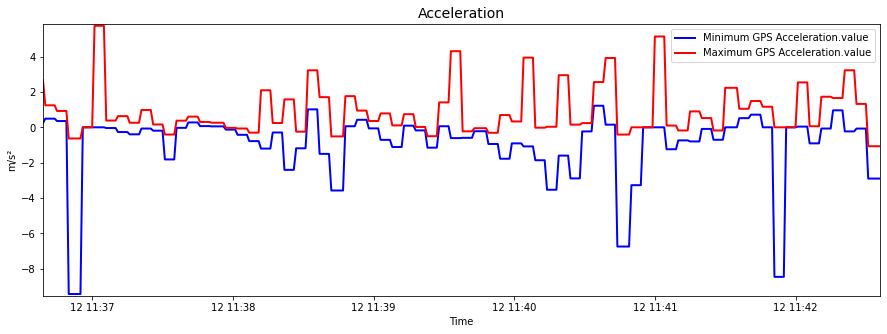

In [6]:
%matplotlib inline
# set a figure of size (15,5):
fig = plt.figure(figsize = (15,5))

plt.xlim(df.index[0],df.index[-1])
plt.ylim((df['Minimum GPS Acceleration.value'].min()-0.1), (df['Maximum GPS Acceleration.value'].max()+0.1))
plt.plot(df['Minimum GPS Acceleration.value'], data= df, marker='', color='blue', linewidth=2)
plt.plot(df['Maximum GPS Acceleration.value'], data= df, marker='', color='red', linewidth=2)

# set the plot title:
plt.title('Acceleration', fontsize=14)

# set the x-axis label:
plt.xlabel('Time',fontsize=10)

# set the y-axis label:
plt.ylabel('m/s²',fontsize=10)

# add a legend to the plot:
plt.legend()

# save the output to the pre-defined output directory:
plt.savefig(root_dir + 'accelaration.png')

# show the chart:
plt.show();

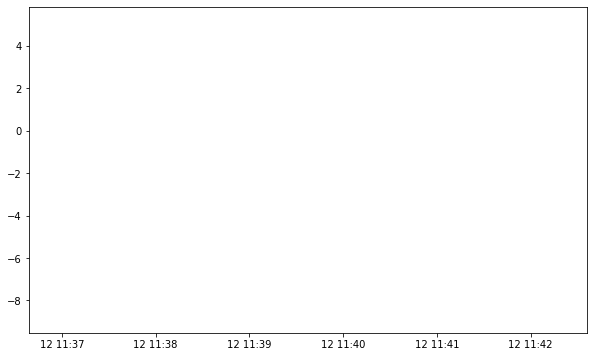

In [7]:
# set a figure of size (10,6):
fig = plt.figure(figsize=(10,6))
# set subplot grid parameters (1x1 grid, 1st subplot):
ax1 = fig.add_subplot(1,1,1)
# add limits on the x axis defined by the sample period (0 is the first observation, -1 the final observation):
ax1.axis(xmin = df.index[0], xmax = df.index[-1])
# add limits on the y-axis defined by minimum and maximum of the respective series, incorporate some additional room:
ax1.axis(ymin= (df['Minimum GPS Acceleration.value'].min()-0.1), ymax=(df['Maximum GPS Acceleration.value'].max()+0.1))

text = fig.text(0.05, 0.05, "",
        horizontalalignment='left',
        verticalalignment='center', fontsize=15, color='orange')

In [8]:
# define the function animate, which has the input argument of i:
def animate(i):
#   set the variable data to contain 0 to the (i+1)th row:
  data =  df.iloc[:int(i+1)]  #select data range
  #   initialise xp as an empty list:
  xp = []
  #   initialise yp as an empty list:
  yp = []
  #   initialise zp as an empty list:
  zp = []
  
#   set the variable lines as equal to the variable data:
  lines = data

#   for a line in lines:
  for line in lines:
    #     x is equal to the index (time domain):
    xp = data.index
    #     y data
    yp = data['Minimum GPS Acceleration.value']
    #     z data
    zp = data['Maximum GPS Acceleration.value']

  #   clear ax(1):
  ax1.clear()
  
  # plot min acc
  ax1.plot(xp, yp)
  # plot max acc
  ax1.plot(xp, zp)

  #   provide a label for the x-axis:
  plt.xlabel('Time',fontsize=12)
  #   provide a label for the y-axis:  
  plt.ylabel('m/s²',fontsize=12)
  #   provide a plot title:   
  plt.title('Acceleration',fontsize=14)
  text.set_text(df["time"].iloc[i])
  

In [9]:
# calculate fps
# import dateutil
# total_mesaurements = len(df)
# print(total_mesaurements)
# s = df['time'].iat[0]
# e = df['time'].iat[-1]
# length_s = e-s
# fps = length_s.seconds / total_mesaurements
fps = 1
fps

1

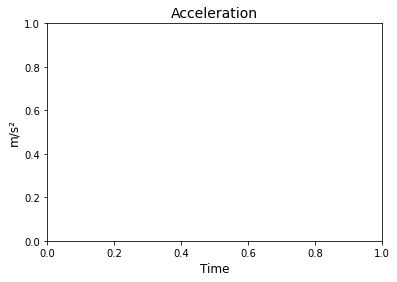

In [10]:
# call Matplotlib animation.Funcanimation, providing the input arguments of fig, animate, the number of frames and an interval:
interval_ms = int(fps * 1000)
ani = animation.FuncAnimation(fig, animate, frames = len(df), interval=interval_ms)

# Use the 'ffmpeg' writer:
Writer = animation.writers['ffmpeg']

# Set the frames per second and bitrate of the video:
writer = Writer(fps=1/interval_ms*1000, metadata=dict(artist='Me'), bitrate=1800)
# save the animation to the predefined output directory:
ani.save(root_dir +'animation_video_interpol.mp4', writer=writer)